In [ ]:
import tensorflow as tf
from keras.datasets import cifar10
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l2
from keras.models import Sequential

**DESCRIPTION OF THE CODE**: 

I used **Cifar10** a dataset made by the **Canadian Institute for Advanced Researches**. It contains 60k images, each one with a low resolution of **32x32**. It's made to test and improve classification tasks, also because is challenging have good accuracy measures due to the low oresolution of each image. The **10 different classes**, each one with 6k images, are:

1. airplanes
2. cars
3. birds
4. cats
5. deer
6. dogs
7. frogs
8. horses
9. ships
10. trucks


**Importing the dataset** 

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


It's also nice to have just a little overview of each class of this dataset

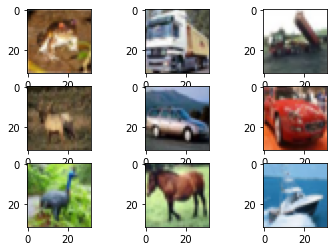

In [ ]:
from matplotlib import pyplot as plt

for i in range(9):  
  plt.subplot(330 + 1 + i)
  im = x_train[i].reshape((32,32,3))
  plt.imshow(im)
plt.show()

### Train the model

**DESCRIPTION OF THE CODE**:

My goal to achieve a good classification score on CIFAR10, knowing is a challinging task reach a 0.7 accuracy when we use a CNN and we don't want a too complex layer's structure. So I decided to use keras.Sequential to build a linear stack of layers, using:

1. Conv2D
2. BatchNormalization
3. MaxPooling2D
4. Dense Layer

Also in the model I added some dropout layers to reduce overfitting, that was not really a problem, also because I did **Data Augmentation** on the train set, using ééImageDataGenerator** from **keras_preprocessing**, trying to virtually increase the train set dimension, and reduce the gap from this one and ther real population I'm trying to classify.

I used also, **Adam** as optimizer, using a customized learing rate, and **SparseCategoricaAccuracy** as a measure of robustness of the model during the classification.

During model.fit I insered some checkpoints, saving only the model that improved in that iteration the SparseCategorcalAccuracy on validation set. 

Finally, I also used Google's GPU on training procedure to speed up execution time, that was like 35 times faster







In [ ]:
§%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
/device:GPU:0
Num GPUs Available:  1


Need to disable eager execution for some problem with tensorflow later

In [ ]:
tf.compat.v1.disable_eager_execution()

Here I define a fuction to build my Keras Sequential model 

In [ ]:
 def kerasmodel(input_shape):
  model = Sequential()

  model.add(Conv2D(filters=96, kernel_size=(3,3),padding='same',input_shape=input_shape))
  model.add(Activation('relu'))

  model.add(Conv2D(filters=96, kernel_size=(3,3), strides=2,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Conv2D(filters=192, kernel_size=(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(filters=192, kernel_size=(3,3), strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10, activation="softmax"))
  return model

Now I define my ImageDataGenerator object to implement **Data Augmentation** on Cifar10 dataset

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)


Now let's compile the model and start the training procedure

In [ ]:
model = kerasmodel((32,32,3)) #define the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
batch_size = 128
STEP_SIZE_TRAIN= len(x_train)//batch_size
STEP_SIZE_VALID= len(x_test)//batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

390 78


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestmodel.h5',
    verbose=1,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [checkpoint]#, stopper]

Train the model

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(
        datagen_train.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch = STEP_SIZE_TRAIN, 
        epochs=120,
        validation_data = datagen_test.flow(x_test, y_test, batch_size=batch_size),
        validation_steps= STEP_SIZE_VALID,
        callbacks=callbacks, 
        verbose = 1)

Epoch 1/120
390/390 [==============================] - 24s 61ms/step - loss: 2.1629 - sparse_categorical_accuracy: 0.2470 - val_loss: 2.3050 - val_sparse_categorical_accuracy: 0.1815

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.18149, saving model to bestmodel.h5
Epoch 2/120
390/390 [==============================] - 24s 61ms/step - loss: 1.7164 - sparse_categorical_accuracy: 0.3728 - val_loss: 1.7466 - val_sparse_categorical_accuracy: 0.3925

Epoch 00002: val_sparse_categorical_accuracy improved from 0.18149 to 0.39253, saving model to bestmodel.h5
Epoch 3/120
390/390 [==============================] - 23s 60ms/step - loss: 1.5582 - sparse_categorical_accuracy: 0.4334 - val_loss: 2.1393 - val_sparse_categorical_accuracy: 0.3208

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.39253
Epoch 4/120
390/390 [==============================] - 23s 60ms/step - loss: 1.4431 - sparse_categorical_accuracy: 0.4805 - val_loss: 2.5672 - val_sparse_categor

**My best results:**

I did some tests on different layers configurations, starting from a core one, made only by Conv2d and two dense layer at the end. Then I added Maxpool and Batchnormalization to check if the results improved. And this is what I obtained.

1.   **Olny with Conv2d and Dense:**  layes loss: 0.8688 - sparse_categorical_accuracy: 0.7002
and  **val_sparse_categorical_accuracy : 0.72987**  
2.   **Adding Maxpool2D**: loss: 0.8455 - sparse_categorical_accuracy: 0.7020 - val_loss: 0.7830 - **val_sparse_categorical_accuracy: 0.7343**
3. **Adding also BatchNorm**: loss: 0.7304 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7360 - **val_sparse_categorical_accuracy: 0.7489**


So I obtained general improvements adding MaxPooling and Batchnormalization after Convolution











So, let's save the model on my Drive Folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model.save("gdrive/MyDrive/CIFAR10") 

INFO:tensorflow:Assets written to: gdrive/MyDrive/CIFAR10/assets


Resources:

1. For the dataset : https://www.cs.toronto.edu/~kriz/cifar.html
2. For Keras Sequential : https://keras.io/guides/sequential_model/
3. For Augmentation : https://keras.io/api/preprocessing/image/

### Attack the Model
**Training a model is only the beginning, I also attacked my model*** 


There are a number of libraries for crafting an adversarial attack, and I used the [Adversarial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox). 


**DESCRIPTION OF THE CODE**: 

Again, working on CIFAR is not a easy task to classify properly, so I decided to attack my model and observe how this perform then. I used **adversarial-robustness-toolbox** 

In [ ]:
pip install adversarial-robustness-toolbox #to attack the model 

Here are the need libraries for this second task

In [ ]:
from art.estimators.classification import KerasClassifier
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from sklearn.metrics import accuracy_score as accuracy 
from matplotlib import pyplot as plt

Reload the model

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model("gdrive/MyDrive/CIFAR10.h5")

Define the classifier and train steps as are defined on library's GitHub

In [ ]:
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
classifier = TensorFlowV2Classifier(
    model=model1,
    train_step=train_step,
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    nb_classes=10,
    input_shape=(32, 32, 3),
    clip_values=(0, 1),)

Normalizing every value by hand on train and test again

In [ ]:
#Normalizing every value
x_train = x_train / 255.0
x_test = x_test / 255.0

Let's check how is a random image before attacking the model

The image is : 9208


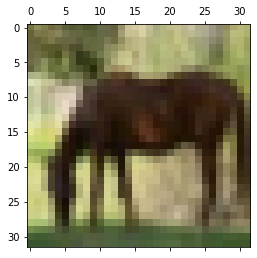

In [ ]:
from random import randrange

n = randrange(len(x_test))
print('The image is :', n)

plt.matshow(x_test[n])
plt.show()


First attack methos is **FGSM**.

This method attack the method exploiting the sign of the gradient associated with the backpropagation method of my model.
First try is made with epsilon value of 0.1.
I've also checked the accuracy score, the average perturbation and what the image look like after the generation


Eps value=0.1
Accuracy on adversarial test examples: 11.899999999999999%
Average perturbation: 0.10


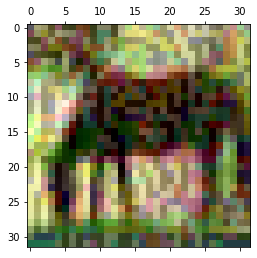

In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print("Eps value=0.1")
print("Accuracy on adversarial test examples: {}%".format(accuracy(np.argmax(predictions, axis=1),y_test) * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
plt.matshow(x_test_adv[n])
plt.show()

Let' try with a **different epsilon**, now **0.2**

Eps value=0.2
Accuracy on adversarial test examples: 11.09%
Average perturbation: 0.19


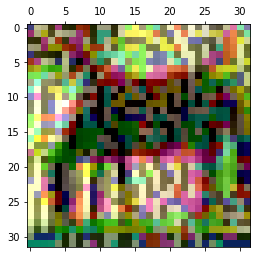

In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print("Eps value=0.2")
print("Accuracy on adversarial test examples: {}%".format(accuracy(np.argmax(predictions, axis=1),y_test) * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
plt.matshow(x_test_adv[n])
plt.show()

Let' try with a **different epsilon**, now **0.3**

Eps value=0.3
Accuracy on adversarial test examples: 10.2%
Average perturbation: 0.27


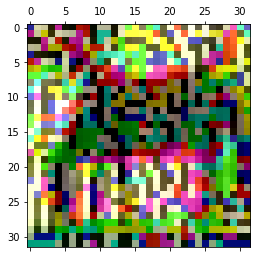

In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print("Eps value=0.3")
print("Accuracy on adversarial test examples: {}%".format(accuracy(np.argmax(predictions, axis=1),y_test) * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
plt.matshow(x_test_adv[n])
plt.show()

Let's try a different approach from the known FastGradientMethod, so I use **JSMA**. This is a more advanced approach that basically saturate a few pixels in a given image to their maximum or minimum values. And that's enough to significatively reduce classification accuracy of our model

In [ ]:
from art.attacks.evasion import SaliencyMapMethod


Eps value=0.1
Accuracy on adversarial test examples: 3.26%
Average perturbation: 0.01


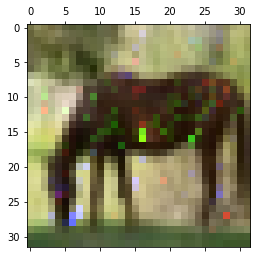

In [ ]:
attack = SaliencyMapMethod(classifier=classifier, theta =0.1, gamma=0.2, batch_size=128)
x_test_adv = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print("Eps value=0.1")
print("Accuracy on adversarial test examples: {}%".format(accuracy(np.argmax(predictions, axis=1),y_test) * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
plt.matshow(x_test_adv[n])
plt.show()